In [95]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수
from sklearn.model_selection import train_test_split
import os,glob
#!pip install xlsxwriter 
import xlsxwriter
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import tqdm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import collections
from scipy.stats import beta
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
import scipy.io as sio

# 데이터 불러오기

-> 데이터 설명 : 사용한 데이터는 CWRU로 베어링 모터 데이터 셋이다.
총 클래스(Normal, B, IR, OR)는 4개가 존재하며 단변량 데이터 셋이다.

각 클래스의 샘플링 주파수는

Normal = 48k

B = 12K

IR = 12K

OR = 12K 이다.

Normal은 4초간 데이터가 수집되어 약 48000 X 4개의 데이터 포인트가 존재한다.

B,IR,OR은 각 10초간 데이터가 수집되어 개별적으로 약 120000 X 10개의 데이터 포인트가 존재한다.

실험에 대한 설계는 Normal Class만 Normal로 나머지 3개의 클래스는 Abnormal로 정의했다.

In [3]:
# B, IR , OR , Normal 4개의 Class 존재 
# B Class는_샘플링 주파수 = 12K 
# IR Class는 샘플링 주파수 = 12K
# Normal Class는 샘플링 주파수 = 48k
# OR Class는 샘플링 주파수 12K
B_Sampling_Freq_12 = glob.glob('C:/Users/82105/Desktop/CWRU_Data/12K_DE/B*.mat')
IR_Sampling_Freq_12 = glob.glob('C:/Users/82105/Desktop/CWRU_Data/12K_DE/IR*.mat')
Normal_Sampling_Freq_48 = glob.glob('C:/Users/82105/Desktop/CWRU_Data/12K_DE/Nor*.mat')
OR_Sampling_Freq_12 = glob.glob('C:/Users/82105/Desktop/CWRU_Data/12K_DE/OR*.mat')

In [4]:
def Read_loadmat(file_path):
  arr = sio.loadmat(file_path)
  arr = arr[list(arr.keys())[3]]
  tensor = torch.tensor(arr) 
  return tensor 

In [5]:
def Concat(Total_file_list):
    Total_tensor = torch.tensor([])
    for i in range(len(Total_file_list)):
        tensor = Read_loadmat(Total_file_list[i])
    #print(tensor)
        Total_tensor = torch.cat([Total_tensor,tensor])
    #print(Total_tensor)
    return Total_tensor
#ten1 = Read_loadmat(B_Sampling_Freq_12[0])

In [6]:
B_12 = Concat(B_Sampling_Freq_12)
IR_12 = Concat(IR_Sampling_Freq_12)
OR_12 = Concat(OR_Sampling_Freq_12 )
Normal_48 = Concat(Normal_Sampling_Freq_48 )

In [7]:
# B_Class는 Label 1 , IR Class는 Label 2, OR Class는 Label3, Normal Class는 Label 0
#

DataFrame_B = pd.DataFrame(B_12)
DataFrame_B['Label']=1

DataFrame_IR = pd.DataFrame(IR_12)
DataFrame_IR['Label']=2

DataFrame_OR = pd.DataFrame(OR_12)
DataFrame_OR['Label']=3

DataFrame_Normal = pd.DataFrame(Normal_48)
DataFrame_Normal['Label']=0

In [8]:
DataFrame_Total = pd.concat([DataFrame_Normal,DataFrame_B,DataFrame_IR,DataFrame_OR])
DataFrame_Total.columns = ['x','Label']
DataFrame_Total = DataFrame_Total.reset_index(drop=True)

In [9]:
# 샘플링 주파수를 고려하여 0.1초 단위로 주파수 변환 단위 만들기
# Ex) Normal 데이터는 샘플링 주파수가 48k 즉 1초에 48000개의 데이터가 수집됩니다.
# 이것을 0.1초 단위로 수집된 데이터 즉 4800개의 데이터에서 주파수 변환합니다. 
Normal_Squ = 4800
Normal_FFT_len = int(len(DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==0]) / Normal_Squ)

B_Squ = 1200
B_FFT_len = int(len(DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==1]) / B_Squ)

IR_Squ = 1200
IR_FFT_len = int(len(DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==2]) / IR_Squ)

OR_Squ = 1200
OR_FFT_len = int(len(DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==3]) / OR_Squ)

In [16]:
for i in range(Normal_FFT_len):
    if i == 0:
        globals()['Normal_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==0].iloc[0:Normal_Squ,:]
    else:
        globals()['Normal_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==0].iloc[i*Normal_Squ:(i+1)*Normal_Squ,:]
                  

In [17]:
Normal_file_list = ['Normal_Data'+str(i) for i in range(Normal_FFT_len)]

In [ ]:
for i in range(B_FFT_len):
    if i == 0:
        globals()['B_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==1].iloc[0:B_Squ,:]
    else:
        globals()['B_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==1].iloc[i*B_Squ:(i+1)*B_Squ,:]

In [ ]:
B_file_list = ['B_Data'+str(i) for i in range(B_FFT_len)]

In [ ]:
for i in range(IR_FFT_len):
    if i == 0:
        globals()['IR_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==2].iloc[0:IR_Squ,:]
    else:
        globals()['IR_Data{}'.format(i)] = DataFrame_Total.loc[DataFrame_Total.iloc[:,-1]==2].iloc[i*IR_Squ:(i+1)*IR_Squ,:]

In [ ]:
IR_file_list = ['IR_Data'+str(i) for i in range(IR_FFT_len)]

# 주파수 변환

In [ ]:
# 샘플링 주파수 48k에 대한 FFT

def FFT_48(file_list,label):
    FS = 48000                                   
    T = 1/FS                                     
    te = 10                                      
    t = np.arange(0,te,T)                               
    colum = [i*10 for i in range(500)]
    
    df_concat = pd.DataFrame([],columns=colum)
    for dr in file_list:

        df = globals()[dr].iloc[:,0]
        #df = df.iloc[:,-3]  # U만추출 
        count = 0
        NFFT = len(df)
        k=np.arange(NFFT)
        f0=k*FS/NFFT
        f0=f0[range(math.trunc(NFFT/2))]
        Y=np.fft.fft(df)/NFFT
        Y=Y[range(math.trunc(NFFT/2))] 
        amplitude_Hz = 2*abs(Y)
        f0 = f0[:500]                       
        amplitude_Hz = amplitude_Hz[:500]   
        df_Hz = pd.DataFrame(amplitude_Hz)
        df_Hz = df_Hz.T
        df_Hz.columns = f0
        df_Hz['label'] = [label]
        #print(df_Hz)
        df_concat = pd.concat([df_concat,df_Hz])
        
    return df_concat

In [ ]:
# 샘플링 주파수 12k에 대한 FFT

def FFT_12(file_list,label):
 
    FS = 12000                                  
    T = 1/FS                                    
    te = 10                                      
    t = np.arange(0,te,T)                              
    colum = [i*10 for i in range(500)]
    
    df_concat = pd.DataFrame([],columns=colum)
    for dr in file_list:

        df = globals()[dr].iloc[:,0]
        #df = df.iloc[:,-3]  # U만추출 
        count = 0
        NFFT = len(df)
        k=np.arange(NFFT)
        f0=k*FS/NFFT
        f0=f0[range(math.trunc(NFFT/2))]
        Y=np.fft.fft(df)/NFFT
        Y=Y[range(math.trunc(NFFT/2))] 
        amplitude_Hz = 2*abs(Y)
        f0 = f0[:500]                       
        amplitude_Hz = amplitude_Hz[:500]   
        print(amplitude_Hz)
        df_Hz = pd.DataFrame(amplitude_Hz)
        df_Hz = df_Hz.T
        df_Hz.columns = f0
        df_Hz['label'] = [label]
        #print(df_Hz)
        df_concat = pd.concat([df_concat,df_Hz])
        
    return df_concat

In [ ]:
Normal_df = FFT_48(Normal_file_list,0)

In [18]:
Normal_df.head(6)

,0,10,20,30,40,50,60,70,80,90,...,4910,4920,4930,4940,4950,4960,4970,4980,4990,label
0,0.025060,0.000510,0.000525,0.000564,0.000343,0.000485,0.000288,0.000475,0.000822,0.000758,...,0.000276,0.000577,0.000070,0.000244,0.000374,0.000085,0.001533,0.001044,0.000669,0.0
0,0.022038,0.000524,0.000616,0.000049,0.000143,0.000277,0.000183,0.000128,0.000276,0.000498,...,0.001016,0.000596,0.000300,0.000316,0.000300,0.000195,0.000616,0.000471,0.000286,0.0
0,0.021983,0.000552,0.000762,0.000236,0.000405,0.000412,0.000927,0.000326,0.000554,0.000961,...,0.001374,0.000471,0.000419,0.000457,0.000294,0.000373,0.000844,0.000532,0.000486,0.0
0,0.023833,0.000388,0.000174,0.000602,0.000154,0.000467,0.001014,0.000230,0.000431,0.000550,...,0.001111,0.000569,0.000284,0.000777,0.000353,0.000138,0.000250,0.000594,0.000377,0.0
0,0.024902,0.001373,0.000369,0.000582,0.000025,0.000111,0.000760,0.000208,0.000046,0.000741,...,0.000355,0.000056,0.000603,0.000517,0.000400,0.000244,0.000137,0.000162,0.000365,0.0
0,0.021446,0.001097,0.000905,0.001130,0.000658,0.000769,0.000587,0.000580,0.000847,0.000786,...,0.001113,0.000263,0.000598,0.000189,0.000392,0.000510,0.000866,0.000407,0.000416,0.0


In [15]:
B_df = FFT_48(B_file_list,1)

In [17]:
B_df.head(6)

,0,10,20,30,40,50,60,70,80,90,...,4910,4920,4930,4940,4950,4960,4970,4980,4990,label
0,0.031721,0.000478,0.000500,0.000971,0.000474,0.000504,0.000393,0.000639,0.000564,0.000494,...,0.000525,0.000150,0.000499,0.000487,0.000678,0.000369,0.000274,0.000235,0.000303,1.0
0,0.030783,0.000235,0.000250,0.000299,0.000260,0.000248,0.000388,0.000065,0.000115,0.000493,...,0.000436,0.000217,0.000811,0.000432,0.000273,0.000167,0.000084,0.000264,0.000186,1.0
0,0.030905,0.000196,0.000173,0.000649,0.000187,0.000207,0.000185,0.000340,0.000338,0.000452,...,0.000295,0.000252,0.000160,0.000679,0.000621,0.000320,0.000218,0.000379,0.000247,1.0
0,0.030529,0.000033,0.000023,0.000535,0.000099,0.000131,0.000412,0.000115,0.000118,0.000765,...,0.001436,0.000496,0.000839,0.000233,0.000370,0.000457,0.000835,0.000850,0.000367,1.0
0,0.030137,0.000099,0.000093,0.000375,0.000130,0.000160,0.000825,0.000257,0.000229,0.000766,...,0.000730,0.000224,0.000380,0.000217,0.000260,0.000515,0.000215,0.000038,0.000323,1.0
0,0.029432,0.000680,0.000669,0.000247,0.000665,0.000654,0.001251,0.000702,0.000745,0.000856,...,0.000068,0.000391,0.000910,0.000126,0.000605,0.000634,0.000376,0.000517,0.000230,1.0


In [ ]:
IR_df = FFT_12(IR_file_list,2)

In [19]:
IR_df.head(6)

,0,10,20,30,40,50,60,70,80,90,...,4910,4920,4930,4940,4950,4960,4970,4980,4990,label
0,0.031056,0.000268,0.000283,0.000455,0.000324,0.000269,0.001321,0.000319,0.000406,0.000391,...,0.001449,0.003555,0.001211,0.002028,0.004166,0.000690,0.000753,0.001063,0.000846,2.0
0,0.031149,0.000138,0.000123,0.000397,0.000133,0.000135,0.001571,0.000181,0.000341,0.000796,...,0.003939,0.002052,0.001209,0.003106,0.000874,0.002239,0.001430,0.001314,0.002143,2.0
0,0.029721,0.001327,0.001313,0.001436,0.001335,0.001378,0.002147,0.001285,0.001454,0.001522,...,0.003748,0.001607,0.002488,0.001494,0.002454,0.002585,0.003393,0.001960,0.001597,2.0
0,0.032375,0.001416,0.001423,0.001374,0.001424,0.001423,0.001833,0.001441,0.001557,0.001678,...,0.004412,0.001609,0.002088,0.001957,0.002101,0.000989,0.002652,0.000467,0.001389,2.0
0,0.031500,0.000738,0.000768,0.000738,0.000775,0.000801,0.001431,0.000785,0.000874,0.000957,...,0.004665,0.001307,0.000784,0.000791,0.001884,0.001549,0.001911,0.001486,0.000926,2.0
0,0.029483,0.000909,0.000899,0.001006,0.000915,0.000877,0.002102,0.000972,0.000878,0.001105,...,0.003480,0.001742,0.002602,0.000344,0.002399,0.001191,0.001415,0.001228,0.001308,2.0


In [ ]:
OR_df = FFT_12(OR_file_list,3)

In [20]:
OR_df.head(6)

,0,10,20,30,40,50,60,70,80,90,...,4910,4920,4930,4940,4950,4960,4970,4980,4990,label
0,0.038250,0.000805,0.000772,0.000816,0.000845,0.000883,0.000844,0.000910,0.000887,0.000819,...,0.000985,0.001063,0.000467,0.001407,0.001542,0.000912,0.001455,0.001176,0.000927,3.0
0,0.038497,0.000313,0.000304,0.000414,0.000290,0.000317,0.000346,0.000205,0.000368,0.000025,...,0.000894,0.001114,0.001473,0.000830,0.001066,0.001262,0.001937,0.000896,0.001112,3.0
0,0.038417,0.000067,0.000058,0.000386,0.000057,0.000129,0.000278,0.000279,0.000277,0.000480,...,0.000602,0.000313,0.001213,0.000604,0.000959,0.001679,0.002635,0.000506,0.000357,3.0
0,0.038668,0.000520,0.000537,0.000613,0.000601,0.000598,0.000418,0.000433,0.000576,0.000882,...,0.001064,0.000733,0.000149,0.001071,0.001334,0.000561,0.001958,0.001056,0.001519,3.0
0,0.038186,0.000270,0.000303,0.000370,0.000357,0.000361,0.000852,0.000262,0.000213,0.000459,...,0.000631,0.000748,0.001327,0.000315,0.001217,0.000676,0.002601,0.000648,0.001826,3.0
0,0.037120,0.000238,0.000231,0.000269,0.000244,0.000208,0.001124,0.000384,0.000507,0.000598,...,0.001973,0.000275,0.002023,0.000521,0.000486,0.000579,0.003333,0.001442,0.000978,3.0


In [90]:
def Plotting(FFT_df):
    plt.plot(FFT_df.columns[:-1], abs(FFT_df.iloc[0,:-1]),'r', linestyle=' ',marker='^')
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')
    plt.title('FFT 시각화')
    #plt.vlines(FFT_df.columns[:-1],0,5000)
    #plt.vlines(FFT_df.columns[:-1], 0, abs(FFT_df.iloc[0,:-1]))
    #plt.xlim([0,5000])
    plt.show()

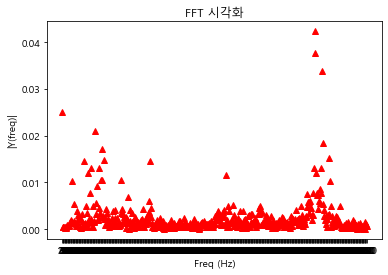

In [94]:
# Normal 데이터 첫 번째 데이터프레임 (0.1초) FFT 결과 시각화
Plotting(Normal_df)

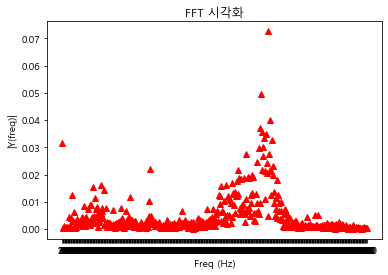

In [92]:
# B Class 데이터 첫 번째 데이터프레임 (0.1초) FFT 결과 시각화
Plotting(B_df)

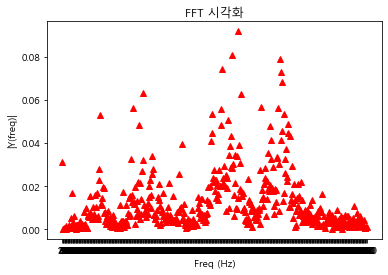

In [93]:
# IR Class 데이터 첫 번째 데이터프레임 (0.1초) FFT 결과 시각화
Plotting(IR_df)

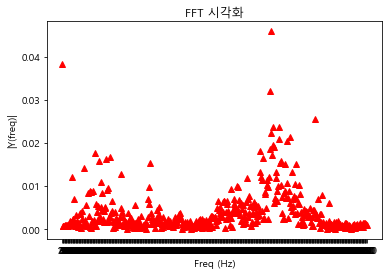

In [91]:
# OR Class 데이터 첫 번째 데이터프레임 (0.1초) FFT 결과 시각화
Plotting(OR_df)

# Autoencoder 모델 정의

In [21]:
x = Normal_df.iloc[:,:-1]
y = Normal_df.iloc[:,-1]

train_x, test_x = train_test_split(x, test_size = 0.2,random_state = 42) 

scaler = StandardScaler()
scaler.fit(train_x)
train_scaler_dataset = scaler.transform(train_x).astype('float32')
test_scaler_dataset =scaler.transform(test_x).astype('float32')

batch_size =4

train_loader = torch.utils.data.DataLoader(dataset = train_scaler_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_scaler_dataset, batch_size = batch_size, shuffle = False)

In [22]:

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,hidden_dim3,hidden_dim4,hidden_dim5):
        super(AutoEncoder, self).__init__()
    
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, hidden_dim1),
          nn.ReLU(),
          nn.Linear(hidden_dim1, hidden_dim2),
          nn.ReLU(),
          nn.Linear(hidden_dim2, hidden_dim3),
          nn.ReLU(),
          nn.Linear(hidden_dim3, hidden_dim4),
          nn.ReLU(),
          nn.Linear(hidden_dim4, hidden_dim5),
          nn.ReLU(),
          nn.Linear(hidden_dim5, 3),
          nn.ReLU()
        )
    
        self.decoder = nn.Sequential(
          nn.Linear(3, hidden_dim5),
          nn.ReLU(),
          nn.Linear(hidden_dim5, hidden_dim4),
          nn.ReLU(),
          nn.Linear(hidden_dim4, hidden_dim3),
          nn.ReLU(),
          nn.Linear(hidden_dim3, hidden_dim2),
          nn.ReLU(),
          nn.Linear(hidden_dim2, hidden_dim1),
          nn.ReLU(),
          nn.Linear(hidden_dim1, input_dim),
          nn.ReLU()
        )
  
    def forward(self, x):
        out = x.view(x.size(0), -1)
        out1 = self.encoder(out)
        out = self.decoder(out1)
        out = out.view(x.size())
        return out, out1
  
    def get_codes(self, x):
        return self.encoder(x)

In [23]:
in_Dim = len(train_scaler_dataset[1])
hi_dim1 = int(in_Dim/2) # 2500
hi_dim2 = int(hi_dim1/2) # 1250
hi_dim3 = int(hi_dim2/2) # 625
hi_dim4 = int(hi_dim3/2) # 312
hi_dim5 = int(hi_dim4/2) # 156
hi_dim6 = 3

AE = AutoEncoder(in_Dim, hi_dim1, hi_dim2,hi_dim3,hi_dim4,hi_dim5)
AE_loss = nn.MSELoss()

In [28]:
def train(model, Loss, optimizer, num_epochs):
    train_loss_arr = []
    test_loss_arr = []

    best_test_loss = 99999999
    early_stop, early_stop_max = 0., 3.
    for epoch in  tqdm_notebook(range(num_epochs)):
        print(epoch)

        epoch_loss = 0.
        for batch_X in train_loader:
            
            batch_X = batch_X#.to(device)
            optimizer.zero_grad()

      # Forward Pass
            model.train()
            outputs,_ = model(batch_X)
            train_loss = Loss(outputs, batch_X) # 배치포함 Loss
            epoch_loss += train_loss.data
           

      # Backward and optimize
            train_loss.backward()
            optimizer.step()

        train_loss_arr.append(epoch_loss / len(train_loader.dataset))
        if epoch % 10 == 0:
            model.eval()

            test_loss = 0.
            for batch_X in test_loader:
                batch_X = batch_X#.to(device)

        # Forward Pass
                outputs,_ = model(batch_X)
                batch_loss = Loss(outputs, batch_X)
                test_loss += batch_loss.data

            test_loss = test_loss
            test_loss_arr.append(test_loss)
            #print(test_loss/len(test_loader.dataset))
            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
            else:
                early_stop += 1

        if early_stop >= early_stop_max:
            break

In [29]:
num_epochs = 30
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE = AE#.to(device)
#CAE = CAE.to(device)

learning_rate = 0.05

AE_optimizer = optim.Adam(AE.parameters(), lr=learning_rate)
#CAE_optimizer = optim.Adam(CAE.parameters(), lr=learning_rate)

train(AE, AE_loss, AE_optimizer, num_epochs)
#train(CAE, CAE_loss, CAE_optimizer, num_epochs)
#Result

<ipython-input-28-cc067a602e77>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in  tqdm_notebook(range(num_epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


# 각 클래스에 대한 Reconstruction Error 산출 

In [30]:
test_scaler_정상_dataset = torch.tensor(test_scaler_dataset)

dataset_B =  torch.tensor(B_df.iloc[:,:-1].values.astype('float32'))
test_scaler_B_dataset = scaler.transform(dataset_B).astype('float32')
test_scaler_B_dataset = torch.tensor(test_scaler_B_dataset)

dataset_IR =  torch.tensor(IR_df.iloc[:,:-1].values.astype('float32'))
test_scaler_IR_dataset = scaler.transform(dataset_IR).astype('float32')
test_scaler_IR_dataset = torch.tensor(test_scaler_IR_dataset)

dataset_OR =  torch.tensor(OR_df.iloc[:,:-1].values.astype('float32'))
test_scaler_OR_dataset = scaler.transform(dataset_OR).astype('float32')
test_scaler_OR_dataset = torch.tensor(test_scaler_OR_dataset)

C:\Users\82105\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\82105\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
def RE_Total(tensor, ):
    Total_mean = []
    Total = []
    for i in range(len(tensor)):
        outputs = AE(tensor[i].unsqueeze(0))[0].detach()
        output = np.array(outputs)
        원본 = np.array(tensor[i])
        outputs = np.square(np.subtract(output, 원본)) 
        Total.append(outputs)
        outputs_mean = outputs.reshape(1,-1).mean()
        Total_mean.append(outputs_mean)
        

    return Total, Total_mean

In [33]:
Total_B, B = RE_Total(test_scaler_B_dataset)

In [34]:
B_df = pd.DataFrame(B, columns=['B_Class_Reconsturction_Error'])
B_df.describe().iloc[1:]

,B_Class_Reconsturction_Error
mean,3860.898926
std,6828.697266
min,5.805271
25%,38.411149
50%,73.348156
75%,275.271248
max,27660.220703


In [35]:
Total_IR, IR = RE_Total(test_scaler_IR_dataset)

In [37]:
IR_df = pd.DataFrame(IR, columns=['IR_Class_Reconsturction_Error'])
IR_df.describe().iloc[1:]

,IR_Class_Reconsturction_Error
mean,1029.878662
std,1091.191650
min,76.900627
25%,286.903435
50%,542.128540
75%,1115.513428
max,3892.160889


In [38]:
Total_OR, OR = RE_Total(test_scaler_OR_dataset)

In [39]:
OR_df = pd.DataFrame(OR, columns=['OR_Class_Reconsturction_Error'])
OR_df.describe().iloc[1:]

,OR_Class_Reconsturction_Error
mean,673.686707
std,757.258606
min,20.459373
25%,123.099545
50%,275.387115
75%,998.385773
max,4397.525879


In [40]:
Total_Normal, Normal = RE_Total(test_scaler_정상_dataset)

In [43]:
Normal_df = pd.DataFrame(Normal, columns=['Normal_Class_Reconsturction_Error'])
Normal_df.describe().iloc[1:]

,Normal_Class_Reconsturction_Error
mean,1.016354
std,0.169984
min,0.787422
25%,0.892701
50%,0.978592
75%,1.132486
max,1.508038


In [44]:
# Normal Data 같은 경우는 샘플링 개수가 적으므로 Anomlay Score를 정의해주기 위해 Train 데이터와 결합
Normal_dataset = np.concatenate([train_scaler_dataset,test_scaler_정상_dataset])
Total_Normal, Normal = RE_Total(torch.tensor(Normal_dataset))

In [45]:
Normal_df = pd.DataFrame(Normal, columns=['Normal_Class_Reconsturction_Error'])
Normal_df.describe().iloc[1:]

,Normal_Class_Reconsturction_Error
mean,1.003309
std,0.160151
min,0.744992
25%,0.882973
50%,0.974087
75%,1.081966
max,1.835267


# Threshold 정의를 위한 정상 데이터로 X바 차트 구축

- 군 내 개수 4로 설정

1.239428339779377
0.7671911136507988


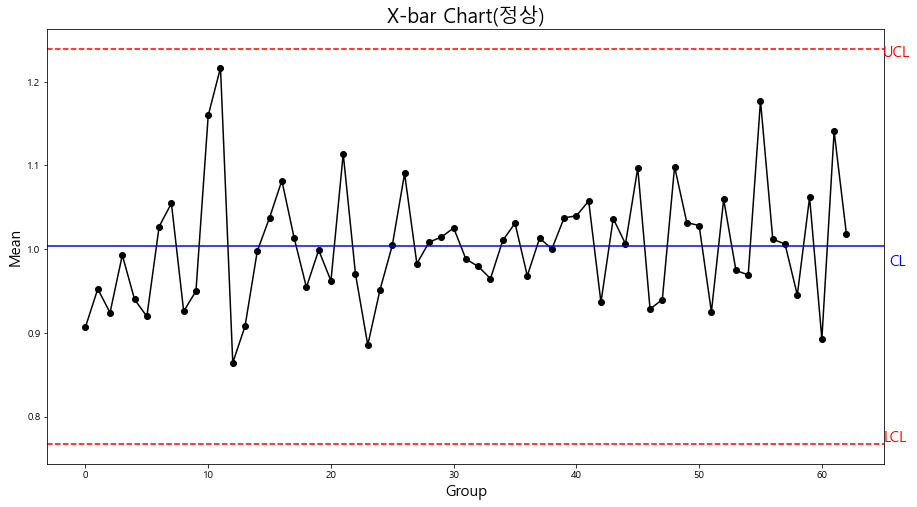

In [48]:
import statistics
k = pd.DataFrame(np.array(Normal_df).reshape(-1,4))
k

x_bar = [] # average 
r = [] # range of the values
s = [] # standard deviation 

for group in np.array(np.array(k)):
    x_bar.append(group.mean())
    r.append(group.max() - group.min())
    s.append(np.std(group))

fig = plt.figure(figsize=(15,8))
plt.plot(x_bar, linestyle='-', marker='o', color='black')
plt.axhline((statistics.mean(x_bar)+0.729*statistics.mean(r)), color='red', linestyle='--')  # 0.729는 군 내개수가 4일때 A2 값
print(statistics.mean(x_bar)+0.729*statistics.mean(r))

정상_UCL = statistics.mean(x_bar)+0.729*statistics.mean(r)
정상_LCL = statistics.mean(x_bar)-0.729*statistics.mean(r)
정상_CL = (statistics.mean(x_bar))
print(정상_LCL)
plt.text(65,1.23,'UCL',color='red',size=15)
plt.text(65.5,0.98,'CL',color='blue',size=15)
plt.text(65,0.77,'LCL',color='red',size=15)
plt.axhline((statistics.mean(x_bar)-0.729*statistics.mean(r)), color='red', linestyle='dashed')
plt.axhline((statistics.mean(x_bar)), color='blue')
plt.title('X-bar Chart(정상)', fontsize=20)
plt.xlabel('Group', fontsize=15)
plt.ylabel('Mean', fontsize=15)
plt.show()

# 구축된 X바 차트에 Anomaly Class( B, IR, OR Class) Mapping & 성능평가

In [51]:
def Phase2(list1,list2,list3,list4):
    Total_mean = list1+list2+list3+list4
    Total_mean_df = pd.DataFrame(np.array(Total_mean).reshape(-1,4))
    x_bar= []
    r = []
    s = [] 
    for group in np.array(np.array(Total_mean_df)):
        x_bar.append(group.mean())
        r.append(group.max() - group.min())
        s.append(np.std(group))
    predict_label=[]
    #print(len(x_bar))
    for x in x_bar:
        if x > 정상_UCL:
            predict_label.append(1)
        else:
            predict_label.append(0)
    True_Label = []
    #print(len(Total_mean)/4)
    for i in range(int(len(Total_mean)/4)):
        if i < len(list1)/4:
            True_Label.append(0)
        else:
            True_Label.append(1)
    count = 0
    No = []
    #print(len(predict_label), print(len(True_Label)))
    for i in range(len(predict_label)):
        if predict_label[i] == True_Label[i]:
            count+=1
        else:
            No.append(i)
    accuracy = count/len(predict_label)
    fig = plt.figure(figsize=(15,8))
    plt.plot(x_bar, linestyle='-', marker='o', color='black')
    plt.axhline((정상_UCL), color='red', linestyle='--')
    plt.axhline((정상_LCL), color='red', linestyle='dashed')
    plt.axhline((정상_CL), color='blue')
    plt.title('Phase2', fontsize=20)
    plt.xlabel('Group', fontsize=15)
    plt.ylabel('Reconstruction Error Mean', fontsize=15)
    plt.show()
    
    return accuracy, predict_label, True_Label, No

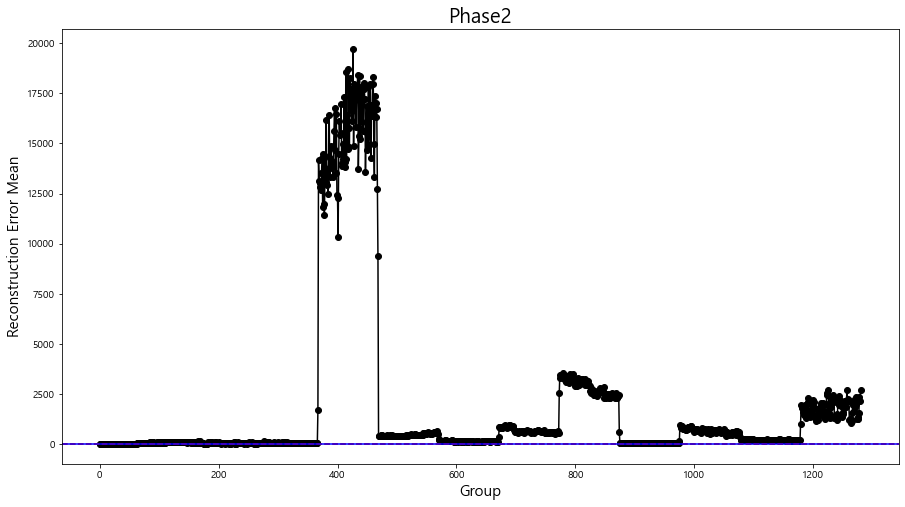

In [97]:
Accuracy,Predict_label,True_label, 틀린_index = Phase2(Normal,B,IR,OR)

In [98]:
print('Accuracy:',Accuracy)
print('실제_Label',True_label)
print('예측_Label',Predict_label)
print('틀린_index',틀린_index )

Accuracy: 1.0
실제_Label [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

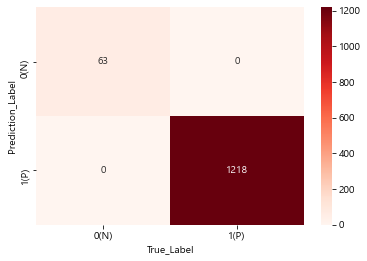

In [99]:
# Confusion Matrix 
# Positive = Abnormal, Negative = Normal

cm2 = confusion_matrix(True_label, Predict_label)
sns.heatmap(cm2, annot = True, fmt = 'd',cmap = 'Reds')
plt.xlabel('True_Label')
plt.ylabel('Prediction_Label')
plt.xticks([0.5,1.5],['0(N)', '1(P)'])
plt.yticks([0.5,1.5],['0(N)', '1(P)'])
plt.show()

In [100]:
# Accuracy_Score

print('Accuracy_Score', accuracy_score(True_label, Predict_label))

Accuracy_Score 1.0


In [101]:
# Precision_Score

print('Precision_Score', precision_score(True_label, Predict_label))

Precision_Score 1.0


In [102]:
# Recall_Score

print('Recall_Score', recall_score(True_label, Predict_label))

Recall_Score 1.0


In [103]:
# F1_Score

print('F1_Score', f1_score(True_label, Predict_label))

F1_Score 1.0
